In [1]:
%matplotlib widget

import os
import pickle
import shutil 

import meep as mp
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
import math
from IPython import embed

In [2]:
# set up simulation constants

resolution = 20

n_air = 1.0000003
n_siox = 1.45
a = 0.5   # lattice period 

#pml_thickness = round(wavelength / 2,3)
pml_thickness = 0.780
height_hole = 5
height_siox = 5+0.780
height_air = 0.3

cell_x = a
cell_y = a
cell_z = round(2*pml_thickness + height_siox + height_air, 3)


center_siox = round(pml_thickness + 0.5*height_siox- 0.5*cell_z, 3)
center_hole = center_siox
center_air = round(pml_thickness + height_siox + 0.5* height_air -0.5*cell_z,3)
#center_air = round(0.5*(pml_thickness + height_air + height_hole) + (pml_thickness+height_siox)-0.5*cell_z,3)

z_siox = pml_thickness+height_siox
z_air = height_hole+height_air+pml_thickness

#z_siox = pml_thickness + height_siox +height_space


In [3]:


k_point = mp.Vector3(0,0,0)

wavelength = 1.55
freq = 1 / wavelength

## initialize matrix for data collection ##
##########################################

num_holes = 15 # this is the number of holes we will build
num_height = 3 # this is the number of heights 
data = np.zeros((4,num_holes))

## set up and build source ##
############################

center_source = round(pml_thickness + height_siox*0.2 - 0.6*cell_z, 3) 
source_cmpt = mp.Ey

sources = [mp.Source(mp.ContinuousSource(frequency=freq),
                    component=source_cmpt,
                    center=mp.Vector3(0,0,center_source),
                    size=mp.Vector3(cell_x,cell_y,0))]



/home/june/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/june/miniconda3/envs/mp/lib/python3.11/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


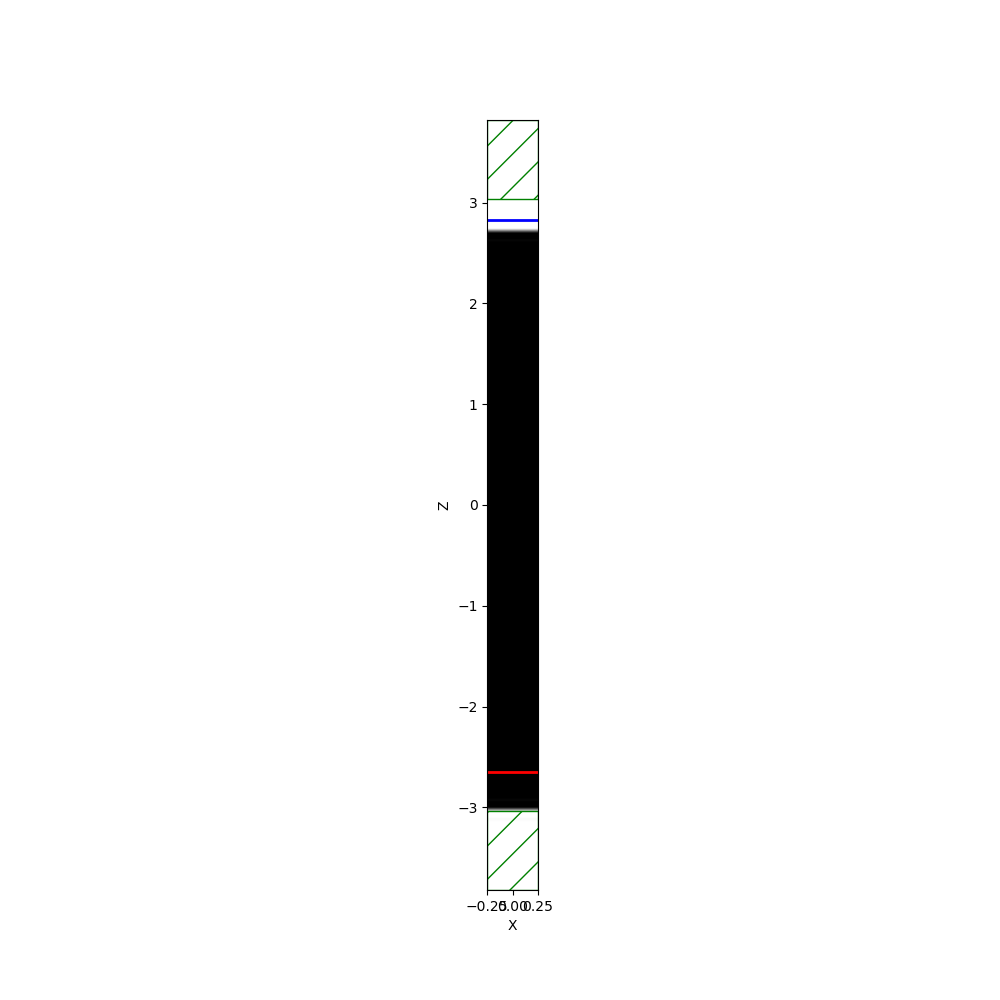

In [4]:
## Set up simulation ##
######################

cell_size = mp.Vector3(cell_x,cell_y,cell_z)
pml_layers = [mp.PML(thickness = pml_thickness, direction = mp.Z)]

if source_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X, phase=+1), #epsilon has mirror symmetry in x and y, phase doesn't matter
                  mp.Mirror(mp.Y, phase=-1)] #but sources have -1 phase when reflected normal to their direction
elif src_cmpt == mp.Ex:                      #use of symmetries important here, significantly speeds up sim
    symmetries = [mp.Mirror(mp.X, phase=-1),
                  mp.Mirror(mp.Y, phase=+1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X, phase=+1),
                  mp.Mirror(mp.Y, phase=+1)]


geometry=[mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_air),
                    center=mp.Vector3(0,0,center_air),
                    material=mp.Medium(index=n_air))]

geometry =[mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_hole), 
                   center=mp.Vector3(0,0,center_hole),
                   material=mp.Medium(index=n_air))]

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_siox),
                    center=mp.Vector3(0,0,center_siox),
                     material=mp.Medium(index=n_air)))



sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=sources,
                    k_point=k_point,
                    boundary_layers=pml_layers,
                    symmetries=symmetries,
                    resolution=resolution)

nfreq = 1
df = 0
fr_center = round(0.5*cell_z - pml_thickness - 0.7*height_air, 3)
fr = mp.FluxRegion(center=mp.Vector3(0,0,fr_center), 
            size=mp.Vector3(cell_x, cell_y, 0))

flux_object = sim.add_flux(freq, df, nfreq, fr)
min_r = 0.0
max_r = 0.245
min_h = 1.02
max_h = 5

#print (geometry)

fig = plt.figure(figsize=(10,10))
plot_plane = mp.Volume(center=mp.Vector3(0,0.0*a,0),
                            size=mp.Vector3(a,0,cell_z))
field_func = lambda x: 20*np.log10(np.abs(x))
sim.plot2D(output_plane=plot_plane
           #fields=mp.Ey
           )
plt.grid(False)
fig.savefig("test.png")

#sim.geometry


In [5]:
sim.run(until=200)

initial_flux = mp.get_fluxes(flux_object)[0]     # initial flux
sim.reset_meep()

geometry =[mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_hole), 
                   center=mp.Vector3(0,0,center_hole),
                   material=mp.Medium(index=n_siox))]

geometry.append(mp.Block(size=mp.Vector3(mp.inf,mp.inf,height_siox),
                    center=mp.Vector3(0,0,center_siox),
                     material=mp.Medium(index=n_siox)))

combined_data = {}
height_list = []

pbar = tqdm(total=num_holes,leave=False)

def run_sim(radius,height,sim) :
    print(radius)
    geometry.append(mp.Cylinder(radius=radius,
                        height=height,
                        axis=mp.Vector3(0,0,1),
                        center=mp.Vector3(0,0,center_hole + 0.5*height_siox - 0.5*height),
                        material=mp.Medium(index=n_air)))
    
    
    sim = mp.Simulation(cell_size=cell_size,
                        geometry=geometry,
                        sources=sources,
                        k_point=k_point,
                        boundary_layers=pml_layers,
                        symmetries=symmetries,
                        resolution=resolution)

    #save_geometry(sim, radius, height)
    
    flux_object = sim.add_flux(freq, df, nfreq, fr)  
    sim.run(until=200)
    res = sim.get_eigenmode_coefficients(flux_object, [1], eig_parity=mp.ODD_Y)
    coeffs = res.alpha

    flux = abs(coeffs[0,0,0]**2)
    phase = np.angle(coeffs[0,0,0]) 

    
    radii_list.append(radius)
    flux_list.append(flux)
    phase_list.append(phase)
    new_heightlist.append(height)
    
    if(radius!=max):
        sim.reset_meep()
        geometry.pop(-1)

    return phase_list, flux_list

def save_geometry(sim, radius, height):
    fig = plt.figure(figsize=(10,10))
    sim.plot2D(output_plane=plot_plane)
    print(radius)
    print(height)
    fig.savefig(f"geo_{radius}_{height}.png")



for h, height in enumerate(np.linspace(min_h,max_h,num_height)):
    radii_list, flux_list, phase_list, new_heightlist = [],[],[],[]
    for r, radius in enumerate(np.linspace(min_r,max_r,num_holes)):
        run_sim(radius,height,sim)
        combined_data[h] = {
            'height' : height,
            'flux' : flux_list,
            'phase' : phase_list,
            'radii' : radii_list,
            'new_height' : new_heightlist 
            }


-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000627995 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0315959 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)


  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]Warning: grid volume is not an integer number of pixels; cell size will be rounded to nearest pixel.


0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00105095 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0302 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000682831 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.0175, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.03125 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00128293 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.035, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0331619 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000745058 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.0525, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.043268 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00158691 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.07, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0435822 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000882149 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.0875, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.044399 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000880957 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.105, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.042794 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00250196 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.1225, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0426979 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000916004 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.14, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.04579 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000880957 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.1575, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0473802 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000727177 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.175, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.046345 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00110698 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.1925, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.047986 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00176096 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.21, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.053323 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000841856 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.2275, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.049973 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.245
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000888109 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,2.23)
          radius 0.245, height 1.02, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.045244 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00126004 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0281138 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000642061 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.0175, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0293179 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000617981 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.035, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0371671 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00115585 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.0525, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0634458 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00134182 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.07, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0625091 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000776052 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.0875, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0642252 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000735998 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.105, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0659301 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000798941 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.1225, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.062295 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000772953 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.14, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.066365 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00123787 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.1575, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0698471 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000829935 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.175, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0647588 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000782013 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.1925, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.077462 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000833988 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.21, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0836971 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000723839 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.2275, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.084295 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.245
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00109386 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,1.235)
          radius 0.245, height 3.01, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.068718 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00087595 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.028301 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.017499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000968933 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.0175, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0320129 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.034999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0012331 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.035, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.047328 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.05249999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000879049 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.0525, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0939291 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.06999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000760078 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.07, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0862651 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.0875
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00159788 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.0875, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0946269 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.10499999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000735998 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.105, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0916731 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.12249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000862122 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.1225, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.093534 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.13999999999999999
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000766039 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.14, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0910189 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.15749999999999997
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000833988 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.1575, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0969238 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.175
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000886917 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.175, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0880849 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.19249999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000813961 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.1925, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.109184 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.20999999999999996
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00148821 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.21, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.115473 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.22749999999999998
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.000773191 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.2275, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.115645 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


0.245
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00097394 s
Working in 3D dimensions.
Computational cell is 0.5 x 0.5 x 7.65 with resolution 20
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,0,-0.15)
          size (1e+20,1e+20,5.78)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     cylinder, center = (0,0,0.24)
          radius 0.245, height 5, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0928838 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

run 0 finished at t = 200.0 (8000 timesteps)
MPB solved for frequency_1(0,0,0.645161) = 0.645161 after 6 iters
Dominant planewave for band 1: (0.000000,0.000000,0.645161)


In [6]:
print(combined_data)

{0: {'height': 1.02, 'flux': [63.655300729483535, 63.655300729483535, 63.454527910618346, 63.29960413667481, 63.021333604103056, 62.740864219356915, 62.44950446451812, 62.25154428784414, 62.109230676652075, 62.19102335585527, 62.49355649234743, 63.06559269163961, 63.836658243345816, 64.67804369666882, 65.1792586274672], 'phase': [0.4643438424591733, 0.4643438424591733, 0.42809602411998776, 0.3939321675443256, 0.3362071613203586, 0.268811855904116, 0.19168526078300102, 0.09668369676594164, -0.008124694394015865, -0.12722230333005966, -0.2621237217522851, -0.41255544234952707, -0.5788408392982993, -0.7621471098241003, -0.899489629199341], 'radii': [0.0, 0.017499999999999998, 0.034999999999999996, 0.05249999999999999, 0.06999999999999999, 0.0875, 0.10499999999999998, 0.12249999999999998, 0.13999999999999999, 0.15749999999999997, 0.175, 0.19249999999999998, 0.20999999999999996, 0.22749999999999998, 0.245], 'new_height': [1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.0

In [7]:
len(data[1])

15

In [8]:
print(combined_data[2]['radii'])

[0.0, 0.017499999999999998, 0.034999999999999996, 0.05249999999999999, 0.06999999999999999, 0.0875, 0.10499999999999998, 0.12249999999999998, 0.13999999999999999, 0.15749999999999997, 0.175, 0.19249999999999998, 0.20999999999999996, 0.22749999999999998, 0.245]


[0.6747765772592434, 0.6747765772592434, 0.6686634331973348, 0.6627668064824861, 0.6528781019059476, 0.6429744594154997, 0.634955765486921, 0.6323577115847184, 0.6380783894868505, 0.6534837574706555, 0.6750614483736405, 0.6918782080259388, 0.6926948478275223, 0.6797389354033746, 0.6708021432502246]
~~


KeyError: 'phase'

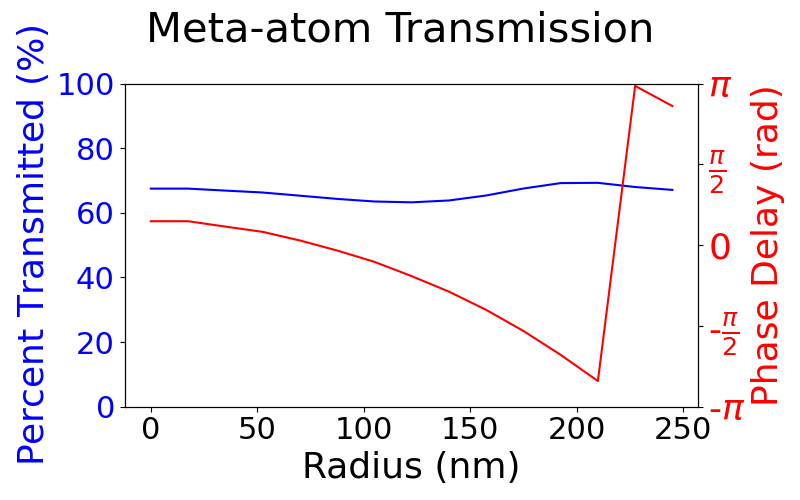

In [10]:
# 2D plot
combined_phase = []


flux_percent = []
for k,j in enumerate(np.linspace(0,num_height-1,2)):
    for v,l in enumerate(np.linspace(0,num_holes-1,num_holes)):
        # combined_data[][]
        x = combined_data[k]['radii']
        y = combined_data[k]['new_height']
        z = combined_data[k]['phase']
        z_1 = combined_data[k]['flux']

for element in z_1:
    flux_percent.append(element / initial_flux)
    

tickfontsize=22
labelfontsize=26
titlefontsize=30

fig,ax = plt.subplots(figsize=(8,5)) # may want to change. Also see DPI keyword

fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

#ax.set_title("Transmission Magnitude",fontsize=titlefontsize)

ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)
ax.set_ylim([0,1])
ax.set_ylabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
#ax.plot(radii,flux_list,'b',label='Transmission')
ax.plot(radii_list, flux_percent, 'b', label='Transmission')
ax.tick_params(axis='y', labelcolor = 'blue')

ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0, 20,40,60,80,100],fontsize=tickfontsize)
#ax.set_yticks([0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels([60,70,80,90,100],fontsize=ticgit config --global user.email "you@example.com"kfontsize)

twin1 = ax.twinx()
#ax[1].set_title("Transmission Phase",fontsize=titlefontsize)S
#ax[1].set_xlabel("Radius (nm)",fontsize=labelfontsize)
#ax[1].set_xticks([0.075,0.100,0.125,0.150,0.175,0.200,0.225,0.250])cd meep

#ax[1].set_xticklabels([75,100,125,150,175,200,225,250],fontsize=tickfontsize)
twin1.set_ylim([-np.pi,np.pi])
twin1.set_ylabel(r'Phase Delay (rad)',fontsize=labelfontsize, color = 'red')
twin1.set_yticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
twin1.set_yticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
twin1.plot(radii_list,combined_data[1]['phase'],'r',label='Phase')
twin1.tick_params(axis='y', labelcolor = 'red')
#ax[1].legend(loc="upper right")
#plt.legend(loc="upper right")
plt.grid(False)
plt.tight_layout()

print(flux_percent)
print('~~')
print(combined_data['phase'])


TypeError: Input z must be 2D, not 1D

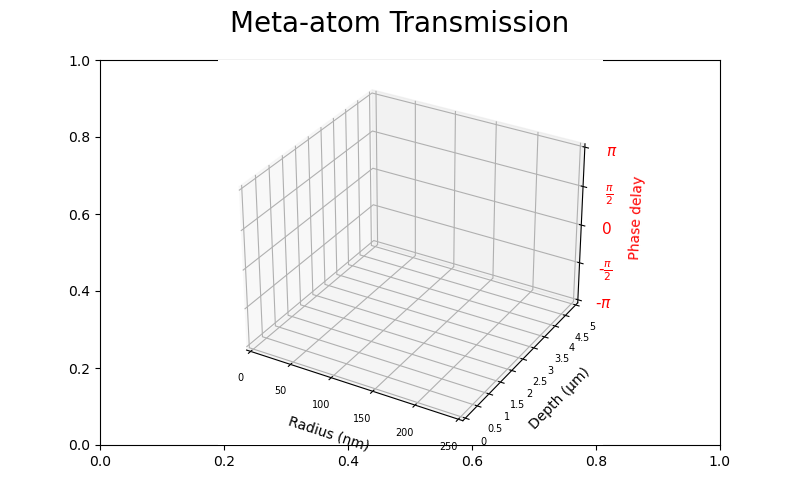

In [11]:
plt.close('all')
# #plt.style.use('seaborn')
# %matplotlib inline
# results = {"radii": radii_list, "height" : height_list, "flux": flux_list, "phase": phase_list}
# # this section plots radius vs. phas and transmission

tickfontsize=7
labelfontsize=10
titlefontsize=20

# #bring back code here!!

fig,ax = plt.subplots(figsize=(8,5))
ax = fig.add_subplot(projection='3d')
fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

# x axis
ax.set_xlim(0, 0.25)
ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)

# y axis
ax.set_ylim(0, 1)
ax.set_ylabel("Depth (µm)",fontsize=labelfontsize)
ax.set_yticks([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=tickfontsize)


# z axis - phase
ax.set_zlim(-np.pi,np.pi)
ax.set_zlabel(r'Phase delay',fontsize=labelfontsize, color = 'red')
ax.set_zticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
ax.set_zticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
ax.tick_params(axis='z', labelcolor = 'red')


# #ax.plot(combined_data[:][radii_list], combined_data[:][flux_list], combined_data[:][height_list], 'b', label='Transmission')

for k,j in enumerate(np.linspace(0,num_height-1,num_height)):
    for v,l in enumerate(np.linspace(0,num_holes-1,num_holes)):
        # combined_data[][]
        x = combined_data[k]['radii']
        y = combined_data[k]['new_height']
        z = combined_data[k]['phase']
        z_1 = combined_data[k]['flux']

#         print(x)
#         print(y)
#         print(z)2866974, -1.0394119867350093, 0.5868561615887135]

#         print(z_1)
#         print("~~")cd code


        ax.contour(x,y,z, cmap='viridis', color='red')

        # ax.plot_surface(combined_data[k]['radii'][k], combined_data[k]['phase'][k], combined_data[k]['height'], cmap=plt.cm.YlGnBu_r)

plt.grid(False)
plt.show()
 

{0: {'height': 1.02, 'flux': [63.655300729483535, 63.655300729483535, 63.454527910618346, 63.29960413667481, 63.021333604103056, 62.740864219356915, 62.44950446451812, 62.25154428784414, 62.109230676652075, 62.19102335585527, 62.49355649234743, 63.06559269163961, 63.836658243345816, 64.67804369666882, 65.1792586274672], 'phase': [0.4643438424591733, 0.4643438424591733, 0.42809602411998776, 0.3939321675443256, 0.3362071613203586, 0.268811855904116, 0.19168526078300102, 0.09668369676594164, -0.008124694394015865, -0.12722230333005966, -0.2621237217522851, -0.41255544234952707, -0.5788408392982993, -0.7621471098241003, -0.899489629199341], 'radii': [0.0, 0.017499999999999998, 0.034999999999999996, 0.05249999999999999, 0.06999999999999999, 0.0875, 0.10499999999999998, 0.12249999999999998, 0.13999999999999999, 0.15749999999999997, 0.175, 0.19249999999999998, 0.20999999999999996, 0.22749999999999998, 0.245], 'new_height': [1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.02, 1.0

/tmp/ipykernel_373181/564377051.py:57: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x,y,z_1, 'o-', cmap='viridis', color='blue')


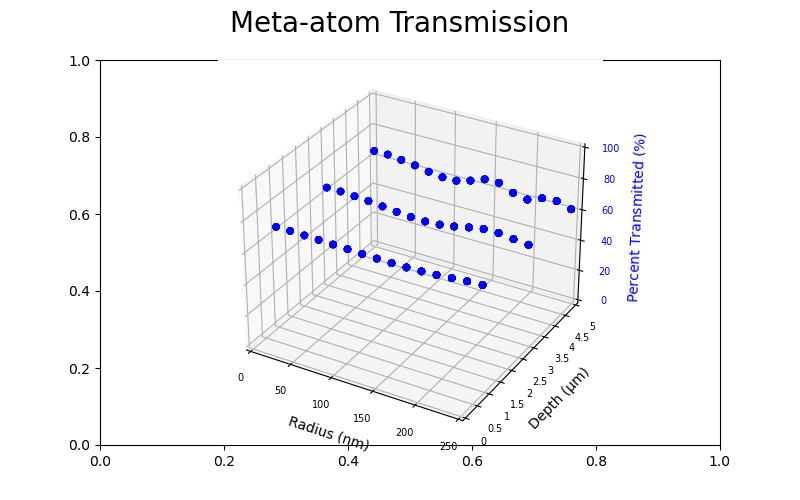

In [12]:

# #plt.style.use('seaborn')
# %matplotlib inline
# results = {"radii": radii_list, "height" : height_list, "flux": flux_list, "phase": phase_list}
# # this section plots radius vs. phas and transmission

tickfontsize=7
labelfontsize=10
titlefontsize=20

# #bring back code here!!

fig,ax = plt.subplots(figsize=(8,5))
ax = fig.add_subplot(projection='3d')
fig.suptitle("Meta-atom Transmission",fontsize=titlefontsize)

# x axis
ax.set_xlim(0, 0.25)
ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize)

# y axis
ax.set_ylim(0, 1)
ax.set_ylabel("Depth (µm)",fontsize=labelfontsize)
ax.set_yticks([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=tickfontsize)


# z axis - phase
ax.set_zlim(61,66)
ax.set_zlabel(r'Percent Transmitted ($\%$)',fontsize=labelfontsize, color = 'blue')
ax.set_zticks([0,20,40,60,80,100])
ax.set_zticklabels([0,20,40,60,80,100],fontsize=tickfontsize)
ax.tick_params(axis='z', labelcolor = 'blue')



# #ax.plot(combined_data[:][radii_list], combined_data[:][flux_list], combined_data[:][height_list], 'b', label='Transmission')

for k,j in enumerate(np.linspace(0,num_height-1,num_height)):
    for v,l in enumerate(np.linspace(0,num_holes-1,num_holes)):
        # combined_data[][]
        x = combined_data[k]['radii']
        y = combined_data[k]['new_height']
        z = combined_data[k]['phase']
        z_1 = combined_data[k]['flux']

        print(combined_data)

#         print(x)
#         print(y)
#         print(z)2866974, -1.0394119867350093, 0.5868561615887135]

#         print(z_1)
#         print("~~")

        ax.scatter(x,y,z_1, 'o-', cmap='viridis', color='blue')
        # ax.plot_surface(combined_data[k]['radii'][k], combined_data[k]['phase'][k], combined_data[k]['height'], cmap=plt.cm.YlGnBu_r)

plt.grid(False)
plt.show()
 

In [ ]:
print(combined_data)

In [ ]:
print(len(combined_data[2]['phase']))

In [ ]:
print(combined_data.keys())

In [ ]:
print(combined_data[0]['height'])

In [13]:
transmission = []
x = []
y = []
phases = []


for k,j in enumerate(np.linspace(0,num_height-1,3)):
    y.append(combined_data[k]['height'])
    # combined_data[][]
    x.append(combined_data[k]['radii'])
    #y.append(combined_data[k]['new_height'])
    phases.append(combined_data[k]['phase'])
    transmission.append(combined_data[k]['flux'])

# # x axis
# ax.set_xlim(0, 0.25)
# ax.set_xlabel("Radius (nm)",fontsize=labelfontsize)
# ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.250])
# ax.set_xticklabels([0,50,100,150,200,250],fontsize=tickfontsize) 

# # y axis
# ax.set_ylim(0, 1)
# ax.set_ylabel("Depth (µm)",fontsize=labelfontsize)
# ax.set_yticks([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
# ax.set_yticklabels([0 ,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=tickfontsize)


# # z axis - phase
# ax.set_zlim(-np.pi,np.pi)
# ax.set_zlabel(r'Phase delay',fontsize=labelfontsize, color = 'red')
# ax.set_zticks([-np.pi, -(0.5*np.pi),0, np.pi / 2, np.pi])
# ax.set_zticklabels([r'-$\pi$',r'-$\frac{\pi}{2}$',r'0',r'$\frac{\pi}{2}$',r'$\pi$'],fontsize=tickfontsize+4)
# ax.tick_params(axis='z', labelcolor = 'red')
    
#x = x[0]
x = np.asarray(x[0])
y = np.asarray(y)
phases = np.asarray(phases)
transmission = np.asarray(transmission)

1.02
0.245


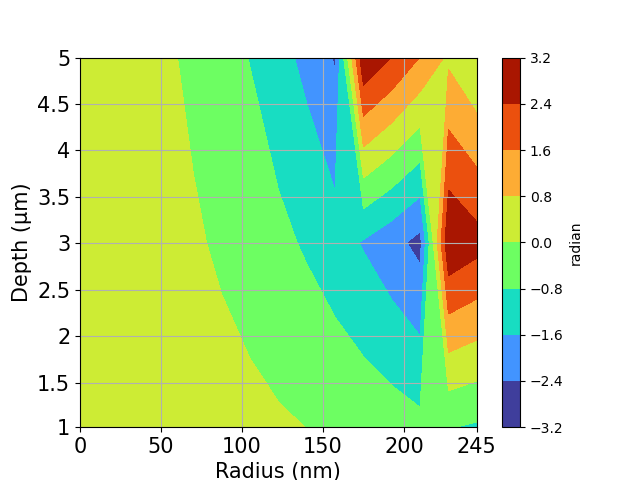

In [16]:
plt.close('all')
[X, Y] = np.meshgrid(x, y)
# plt.style.use('seaborn-v0_8')
#ax.contour(X, Y, phases)
fig,ax = plt.subplots(1,1)
cm= ax.contourf(X,Y,phases, cmap = 'turbo')

ax.set_xlim(0, 0.245)
ax.set_xlabel("Radius (nm)",fontsize=15)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.245])
ax.set_xticklabels([0,50,100,150,200,245],fontsize=15) 

ax.set_ylim(1.02, 5)
ax.set_ylabel("Depth (µm)",fontsize=15)
ax.set_yticks([1.02, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=15)
print(y.min())

print(x.max())

cbar = fig.colorbar(cm,ax=ax)
cbar.set_label('radian')
# plt.imshow(phases, cmap = 'turbo')
# plt.colorbar(label = 'my unit')
ax.grid(True)
plt.show()

1.02
0.245


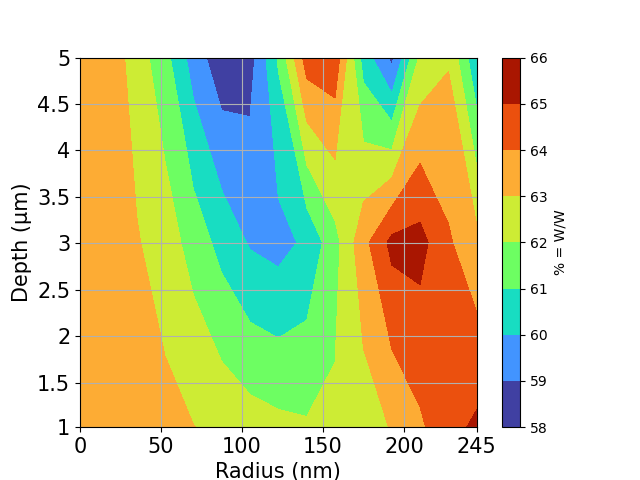

In [17]:
plt.close('all')
#plt.style.use('seaborn-v0_8')
[X, Y] = np.meshgrid(x, y)
#ax.contour(X, Y, phases)
fig,ax = plt.subplots(1,1)
cm = ax.contourf(X,Y,transmission, cmap = 'turbo')

ax.set_xlim(0, 0.245)
ax.set_xlabel("Radius (nm)",fontsize=15)
ax.set_xticks([0.000,0.050,0.100,0.150,0.200,0.245])
ax.set_xticklabels([0,50,100,150,200,245],fontsize=15) 

ax.set_ylim(1.02, 5)
ax.set_ylabel("Depth (µm)",fontsize=15)
ax.set_yticks([1.02, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5])
ax.set_yticklabels([1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],fontsize=15)
print(y.min())

print(x.max())
ax.grid(True)
cbar1=fig.colorbar(cm,ax=ax)
cbar1.set_label('% = W/W')
#plt.colorbar(label='% = W/W')

plt.show()



In [ ]:
print(x.shape)

In [ ]:
print(y)

In [ ]:
print(phases)

In [ ]:
print(phases.shape)

In [ ]:
print(transmission.shape)

In [ ]:
plt.style.available